In [5]:
import compgraph as cg
from autodiff.reverse import gradient, check_gradient, visualize_AD

import matplotlib.pyplot as plt
import warnings

%matplotlib inline

warnings.filterwarnings('ignore')

# set this True if you want to render equations with LaTeX
# You need to have some required pacakages on your machine to do so
# check: https://matplotlib.org/3.1.1/tutorials/text/usetex.html
plt.rc('text', usetex=True)

# Visualizing Reverse AD
## Single Path to a Variable

$$
f(x) = \sin(2\ln x)
$$

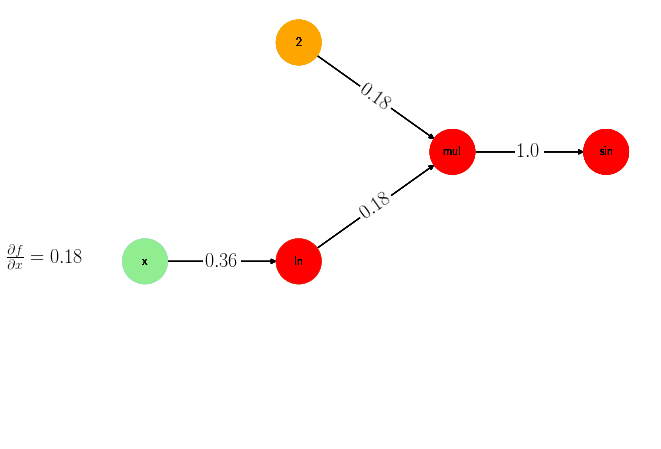

In [6]:
x = cg.variable(2, name='x')
ln = cg.log(x, name='ln')
mul = cg.constant(2, name='2') * ln
mul.name='mul'
f = cg.sin(mul, name='sin')

plt.rcParams['figure.figsize'] = (10, 8)
visualize_AD(f)

## Multiple Paths to a Variable

$$ 
f(x) = x^2 + 2^x
$$

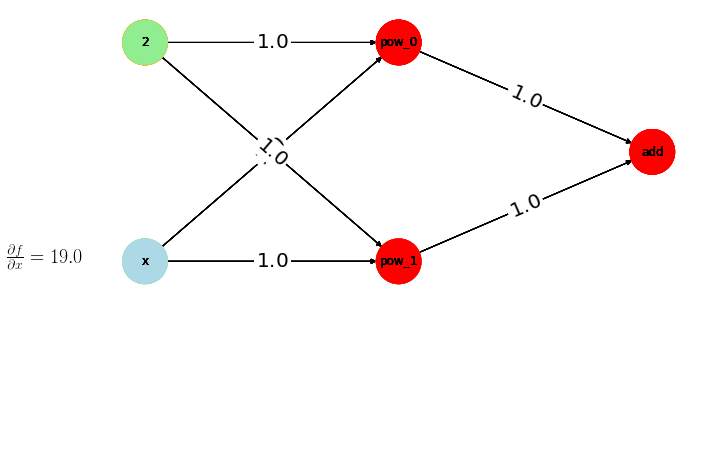

In [3]:
x = cg.variable(4, name='x')
two = cg.constant(2, name='2')
f = x ** two + two ** x
f.name = 'add'

plt.rcParams['figure.figsize'] = (11, 8)
visualize_AD(f)

## Multi-variable Functions

$$
f(x,y,z) = \sin(x+y) + xy^z
$$

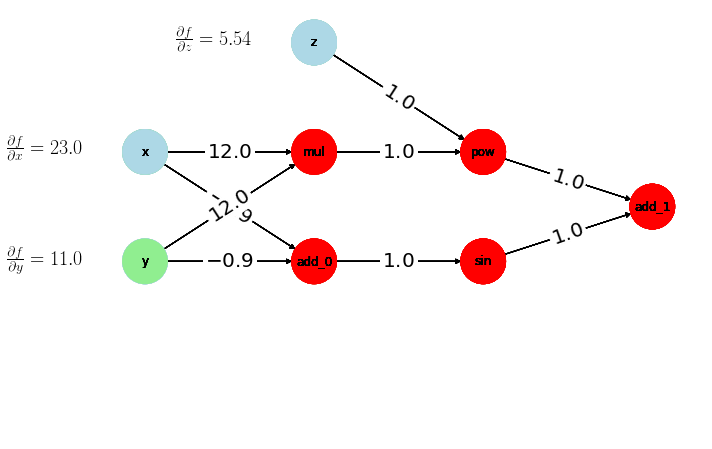

In [4]:
x = cg.variable(1, name='x')
y = cg.variable(2, name='y')
z = cg.variable(3, name='z')

add_0 = x + y
add_0.name = 'add_0'
mul = x*y
mul.name = 'mul'
powr = mul ** z
powr.name = 'pow'
sin = cg.sin(add_0)
sin.name='sin'
add_1 = sin + powr
add_1.name='add_1'

f2 = add_1

plt.rcParams['figure.figsize'] = (11, 8)
visualize_AD(f2)

# Gradient Checking

$$
f(x, y, z) = \sin\left(x^{y + z}\right) - 3z\ln\left(x^2y^3\right)
$$

In [5]:
def func(x,y,z):
    _x = cg.variable(x, 'x')
    _y = cg.variable(y, 'y')
    _z = cg.variable(z, 'z')

    return  cg.sin(_x ** (_y + _z)) - 3 * _z * cg.log((_x ** 2) * (_y ** 3))

f = func(0.5, 4, -2.3)
g = gradient(f)

print("Gradient Checking Result: {}".format(check_gradient(func, [0.5, 4, -2.3], [g[v] for v in ['x', 'y', 'z']])))
print("")
print("∂f/∂x = {}".format(g['x']))
print("∂f/∂y = {}".format(g['y']))
print("∂f/∂z = {}".format(g['z']))

Gradient Checking Result: True

∂f/∂x = 28.59729544270365
∂f/∂y = 4.971684551677847
∂f/∂z = -8.521081615041496


# Simple Neural Network on MNIST Dataset

## Loading and Preprocessing the Data

In [6]:
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
import numpy as np

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
label_bin = LabelBinarizer()
X = X / 255
X, y = shuffle(X, y, random_state=0)
y = label_bin.fit_transform(y) * 1.
training_portion = np.floor(0.8 * len(X)).astype(np.int32)

X_train, y_train = X[: training_portion], y[: training_portion]
X_val, y_val = X[training_portion: ], y[training_portion: ]

## Defining and Running the NN

In [7]:
import numpy as np
import compgraph as cg
from autodiff.reverse import gradient
import sys

def llprint(message):
    sys.stdout.write(message)
    sys.stdout.flush()

def relu(x):
    return cg.where(x > 0, x, 0)

l1_weights = cg.variable(np.random.normal(scale=np.sqrt(2./784), size=(784, 64)), name='l1_w')
l1_bias = cg.variable(np.zeros(64), name='l1_b')
l2_weights = cg.variable(np.random.normal(scale=np.sqrt(2./64), size=(64, 10)), name='l2_w')
l2_bias = cg.variable(np.zeros(10), name='l2_b')
learning_rate = 0.01

def nn(x):
    l1_activations = relu(cg.dot(x, l1_weights) + l1_bias)
    l2_activations = cg.dot(l1_activations, l2_weights) + l2_bias
    
    return l2_activations

last1000_losses = []
for i in range(50000):
    random_sample = np.random.choice(len(X_train), 32)
    x, t = X_train[random_sample], y_train[random_sample]
    
    y = nn(x)
    loss = cg.softmax_cross_entropy(y, t)
    last1000_losses.append(loss)
    
    llprint("\r[%d/%d] Avg. Loss (Last 1k Iterations): %.5f" % (i, 50000, np.mean(last1000_losses)))
    if len(last1000_losses) == 1000:
        last1000_losses.pop(0)
    
    grads = gradient(loss)
    
    l1_weights -= learning_rate * grads['l1_w']
    l2_weights -= learning_rate * grads['l2_w']
    l1_bias -= learning_rate * grads['l1_b']
    l2_bias -= learning_rate * grads['l2_b']

[49999/50000] Avg. Loss (Last 1k Iterations): 0.00013

## Tesing the NN's Accuracy on Validation Data

In [8]:
def softmax(x, axis):
    x_max = cg.max(x, axis=axis, keepdims=True)
    exp_op = cg.exp(x - x_max)
    return exp_op/ cg.sum(exp_op, axis=axis, keepdims=True)

matches = []
for X,y in zip(X_val, y_val):
    nn_out = nn(X)
    prop = softmax(nn_out, 0)
    most_propable = np.argmax(prop)
    matches.append(y[most_propable])

print("Accuracy: {:.2f}%".format(np.mean(matches) * 100))

Accuracy: 97.71%


In [25]:
from compgraph.nodes import *
import numpy as np
import compgraph as cg

def max(array, axis=None, keepdims=False, name=None):
    if not isinstance(array, Node):
        array = ConstantNode.create_using(array)
    opvalue = np.max(array, axis=axis, keepdims=keepdims)
    opnode = OperationalNode.create_using(opvalue, 'max', array, name=name)
    
    print(np.max(array, axis))
    
    opnode.axis = axis

    return opnode

def max_grad(prev_adjoint, node):
    doperand_a = np.where(node.operand_a == node, 1, 0)
    normalizers = np.sum(doperand_a, axis=node.axis, keepdims=True)
    normalized_doperand_a = doperand_a / normalizers

    return [prev_adjoint * normalized_doperand_a, None]

In [26]:
x = cg.variable(np.array([[0, 1, 4], [0, 7, 1]]))
x_max = max(x, axis=0)
print(x_max)
max_grad(1., x_max)

[0 7 4]


[array([[0.5, 0. , 1. ],
        [0.5, 1. , 0. ]]), None]

In [13]:
x[0]

VariableNode([0, 1, 4])

In [18]:
np.array([[0, 1, 4], [0, 7, 1]])

array([[0, 1, 4],
       [0, 7, 1]])

In [20]:
np.max(np.array([[1, 4], [7, 1]]), axis=0)

array([7, 4])

In [24]:
import autodiff.grads as g

cg_x_max = cg.max(x, axis=0)
g.max_grad(1, cg_x_max)

[OperationalNode([[0.5, 0. , 1. ],
                  [0.5, 1. , 0. ]]), None]

In [ ]:
x = cg.variable(np.array([1, 7]))
y = cg.variable